In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pycaret

In [62]:
train = pd.read_csv('./datafile/train.csv')
train

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-01-01 00:00:00,11.5,20.0,23.00,0.20,1.00,0.00,2,28.0,86,15
1,2024-01-01 01:00:00,11.2,18.0,22.00,0.27,2.00,0.00,2,27.0,88,352
2,2024-01-01 02:00:00,9.8,17.0,19.00,0.26,3.00,0.00,2,27.0,90,348
3,2024-01-01 03:00:00,9.7,17.0,17.00,0.26,2.00,0.00,2,26.0,91,1
4,2024-01-01 04:00:00,8.7,16.0,17.00,0.26,2.00,0.00,2,27.0,90,3
...,...,...,...,...,...,...,...,...,...,...,...
1138,2024-02-18 06:00:00,15.6,32.0,14.00,0.05,3.00,0.00,1,25.0,85,30
1139,2024-02-18 07:00:00,17.7,37.0,7.00,0.07,2.29,0.00,0,25.0,84,274
1140,2024-02-18 08:00:00,21.4,48.0,18.00,0.20,2.00,0.14,2,29.0,64,56
1141,2024-02-18 09:00:00,16.3,41.0,22.86,0.16,1.00,0.00,4,31.0,57,60


In [63]:
test = pd.read_csv('./datafile/test.csv')
test

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-02-18 11:00:00,15.9,32.0,24.0,0.13,1.0,0.0,5,33.0,53,48
1,2024-02-18 12:00:00,12.6,33.0,27.0,0.14,1.0,0.0,5,33.0,51,49
2,2024-02-18 13:00:00,10.1,39.0,27.0,0.13,1.0,0.0,4,34.0,50,49
3,2024-02-18 14:00:00,8.7,34.0,28.0,0.13,1.0,0.0,5,33.0,51,52
4,2024-02-18 15:00:00,12.1,32.0,23.0,0.14,1.0,0.0,6,33.0,55,56
...,...,...,...,...,...,...,...,...,...,...,...
488,2024-03-09 19:00:00,6.5,22.0,13.0,0.11,3.0,0.0,2,29.0,73,39
489,2024-03-09 20:00:00,6.6,22.0,12.0,0.12,3.0,0.0,2,28.0,77,32
490,2024-03-09 21:00:00,6.2,21.0,12.0,0.12,3.0,0.0,2,27.0,80,31
491,2024-03-09 22:00:00,5.5,21.0,12.0,0.11,2.0,0.0,3,27.0,82,33


In [64]:
from pycaret.regression import *
train['DATETIMEDATA'] = pd.to_datetime(train['DATETIMEDATA'])
train = train.drop(columns=['TEMP','RH','WD','SO2'])

In [65]:
regression_setup = setup(train, target='PM10', session_id=321, date_features=['DATETIMEDATA'], normalize=True)
best = compare_models()
et = create_model('et')

,Description,Value
0,Session id,321
1,Target,PM10
2,Target type,Regression
3,Original data shape,"(1143, 7)"
4,Transformed data shape,"(1143, 9)"
5,Transformed train set shape,"(800, 9)"
6,Transformed test set shape,"(343, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.0611,23.7962,4.8458,0.8299,0.1221,0.0875,0.0730
lightgbm,Light Gradient Boosting Machine,3.2549,24.9249,4.9651,0.8225,0.1270,0.0933,0.5090
rf,Random Forest Regressor,3.2115,25.0262,4.9551,0.8217,0.1249,0.0913,0.0900
gbr,Gradient Boosting Regressor,3.5750,26.8382,5.1502,0.8092,0.1327,0.1029,0.0480
knn,K Neighbors Regressor,4.0153,31.4526,5.5998,0.7728,0.1508,0.1195,0.0200
ridge,Ridge Regression,4.4897,39.6932,6.2717,0.7135,0.1663,0.1327,0.0130
br,Bayesian Ridge,4.4925,39.6938,6.2719,0.7135,0.1663,0.1328,0.0210
lr,Linear Regression,4.4877,39.6951,6.2718,0.7134,0.1662,0.1327,0.5790
lar,Least Angle Regression,4.4877,39.6951,6.2718,0.7134,0.1662,0.1327,0.0160
ada,AdaBoost Regressor,5.3297,43.4052,6.5729,0.6899,0.1914,0.1753,0.0470


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9956,25.0547,5.0055,0.8278,0.1238,0.0838
1,3.0591,24.8256,4.9825,0.8281,0.1356,0.0950
2,2.7550,23.8026,4.8788,0.8582,0.1102,0.0732
3,3.5207,27.8914,5.2812,0.7761,0.1335,0.1015
4,2.3668,12.3159,3.5094,0.9129,0.0941,0.0732
5,2.7552,16.7189,4.0889,0.8326,0.1145,0.0827
6,3.1746,25.5319,5.0529,0.7927,0.1241,0.0884
7,3.3152,29.8140,5.4602,0.8296,0.1311,0.0932
8,3.2610,26.0459,5.1035,0.7819,0.1284,0.0890


In [66]:
tuned_et_model = tune_model(et)
bagged_model = ensemble_model(tuned_et_model, n_estimators=20)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:11:00
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.7995,24.9044,4.9904,0.8288,0.1365,0.1151
1,3.9399,29.8837,5.4666,0.7931,0.1512,0.1192
2,3.7546,33.1771,5.7600,0.8023,0.1451,0.1079
3,4.0038,36.6795,6.0564,0.7055,0.1499,0.1146
4,3.7913,27.7301,5.2659,0.8038,0.1504,0.1257
5,3.8015,27.0246,5.1985,0.7294,0.1519,0.1200
6,4.4471,38.7592,6.2257,0.6854,0.1650,0.1371
7,4.3620,41.5476,6.4457,0.7625,0.1650,0.1273
8,4.1663,31.8012,5.6393,0.7337,0.1485,0.1200


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0080,23.4470,4.8422,0.8388,0.1223,0.0852
1,3.0305,23.2931,4.8263,0.8388,0.1332,0.0936
2,2.8314,23.8135,4.8799,0.8581,0.1121,0.0760
3,3.4226,26.8405,5.1808,0.7845,0.1304,0.0984
4,2.5501,12.9054,3.5924,0.9087,0.0996,0.0808
5,2.8143,17.1226,4.1379,0.8286,0.1159,0.0844
6,3.1810,25.9345,5.0926,0.7895,0.1240,0.0902
7,3.2848,27.7942,5.2720,0.8411,0.1267,0.0920
8,3.2238,24.1956,4.9189,0.7974,0.1252,0.0894


In [67]:
predictions_from_py = predict_model(bagged_model)
predictions_from_py

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bagging Regressor,2.7970,21.9988,4.6903,0.8719,0.1130,0.0789


,DATETIMEDATA,PM25,O3,CO,NO2,WS,PM10,prediction_label
934,2024-02-09 18:00:00,24.100000,22.860001,0.30,2.00,4,37.0,42.7020
959,2024-02-10 19:00:00,9.800000,26.000000,0.15,2.00,4,24.0,29.7600
1109,2024-02-17 01:00:00,14.300000,17.000000,0.19,1.00,3,52.0,42.4960
817,2024-02-04 21:00:00,13.800000,31.000000,0.29,2.29,3,27.0,28.9745
386,2024-01-17 08:00:00,31.500000,24.000000,0.18,1.00,5,63.0,56.3785
...,...,...,...,...,...,...,...,...
140,2024-01-07 01:00:00,12.100000,10.000000,0.57,8.00,1,22.0,22.1810
383,2024-01-17 05:00:00,24.200001,36.000000,0.21,1.00,4,44.0,43.4085
600,2024-01-26 06:00:00,24.600000,32.000000,0.25,1.00,5,48.0,45.9400
620,2024-01-27 02:00:00,27.700001,29.000000,0.28,1.00,4,51.0,51.8840


In [68]:
now = pd.Timestamp.now()
start_date = now.date()
end_date = start_date + pd.DateOffset(days=7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [69]:
future_data = pd.DataFrame({'DATETIMEDATA': future_dates})
future_data['PM25'] = train['PM25'].mean().round(2)
future_data['O3'] = train['O3'].mean().round(2)
future_data['CO'] = train['CO'].mean().round(2)
future_data['NO2'] = train['NO2'].mean().round(2)
future_data['WS'] = train['WS'].mean().round(2)

In [70]:
predictions = predict_model(bagged_model, data=future_data)
mpdf = pd.DataFrame(predictions, columns=['DATETIMEDATA', 'prediction_label'])
mpdf["prediction_label"] = mpdf["prediction_label"].round(2)

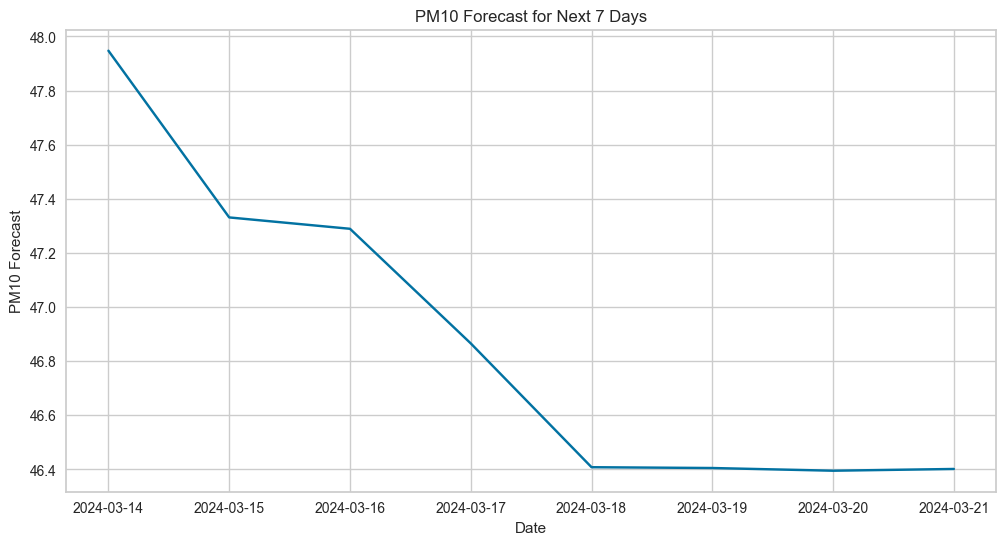

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM10 Forecast')
plt.title('PM10 Forecast for Next 7 Days')
plt.grid(True)
plt.show()

In [72]:
save_model(bagged_model, 'PM10_pipeline')
load_model('PM10_pipeline') 

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\HP\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['DATETIMEDATA'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['PM25', 'O3', 'CO', 'NO2', 'WS'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model',
                 BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=321),
                                  n_estimators=20, random_state=321))])

In [73]:
mean_value = pd.read_csv('./datafile/mean_value.csv')
PM10_mean = mean_value.drop(columns=['PM25','O3','CO','NO2','SO2','WS','TEMP','RH','WD'])

In [74]:
mpdf = mpdf.rename(columns={"DATETIMEDATA": "Date", "prediction_label": "PM10"})
mpdf['Date'] = mpdf['Date'].dt.date
concat = pd.concat([PM10_mean, mpdf], ignore_index=True)
concat.to_csv('./datafile/PM10_mean_and_week_forecast.csv', index=True)

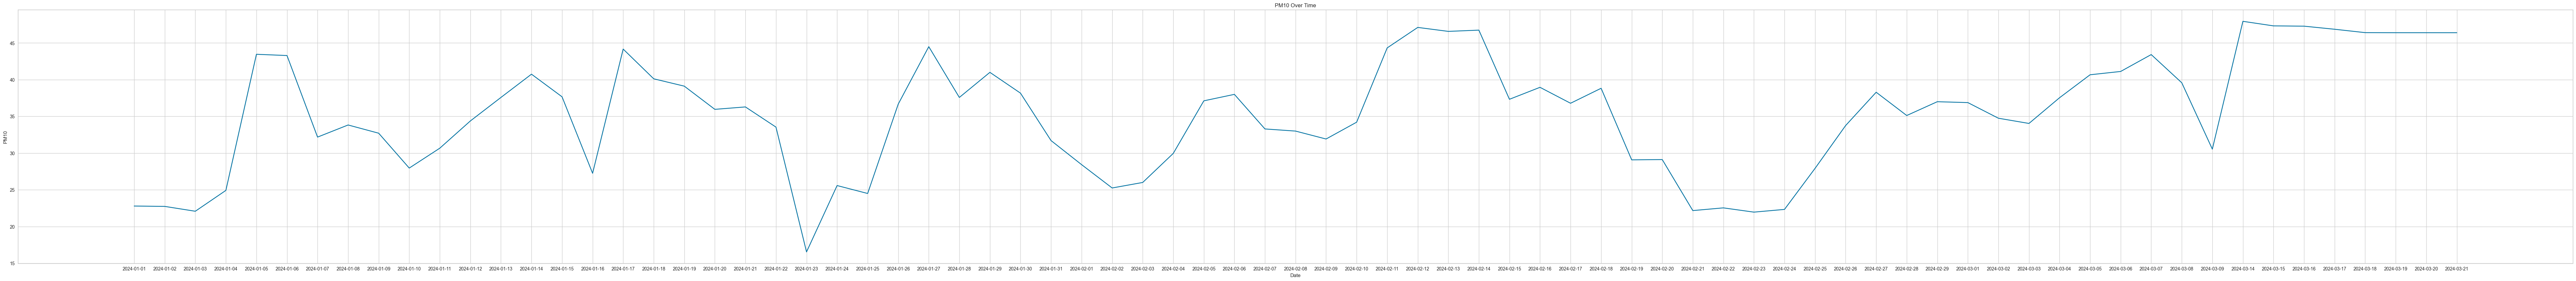

In [75]:
PM10_mean_and_week_forecast = pd.read_csv('./datafile/PM10_mean_and_week_forecast.csv')
dates = PM10_mean_and_week_forecast['Date']
pm10 = PM10_mean_and_week_forecast['PM10']
plt.figure(figsize=(100, 10))
plt.plot(dates, pm10)
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('PM10 Over Time')
plt.grid(True)
plt.show()
plt.show()

In [76]:
evaluate_model(bagged_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [78]:
test['DATETIMEDATA'] = pd.to_datetime(test['DATETIMEDATA'])
pre_PM10_test = predict_model(bagged_model,data=test)
pre_PM10_test

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bagging Regressor,7.1950,83.0600,9.1137,0.2829,0.2654,0.2379


,DATETIMEDATA,PM25,O3,CO,NO2,SO2,WS,TEMP,RH,WD,PM10,prediction_label
0,2024-02-18 11:00:00,15.9,24.0,0.13,1.0,0.0,5,33.0,53,48,32.0,41.7695
1,2024-02-18 12:00:00,12.6,27.0,0.14,1.0,0.0,5,33.0,51,49,33.0,34.6100
2,2024-02-18 13:00:00,10.1,27.0,0.13,1.0,0.0,4,34.0,50,49,39.0,29.9120
3,2024-02-18 14:00:00,8.7,28.0,0.13,1.0,0.0,5,33.0,51,52,34.0,26.2965
4,2024-02-18 15:00:00,12.1,23.0,0.14,1.0,0.0,6,33.0,55,56,32.0,34.2070
...,...,...,...,...,...,...,...,...,...,...,...,...
488,2024-03-09 19:00:00,6.5,13.0,0.11,3.0,0.0,2,29.0,73,39,22.0,25.5495
489,2024-03-09 20:00:00,6.6,12.0,0.12,3.0,0.0,2,28.0,77,32,22.0,25.4315
490,2024-03-09 21:00:00,6.2,12.0,0.12,3.0,0.0,2,27.0,80,31,21.0,25.3285
491,2024-03-09 22:00:00,5.5,12.0,0.11,2.0,0.0,3,27.0,82,33,21.0,26.2270


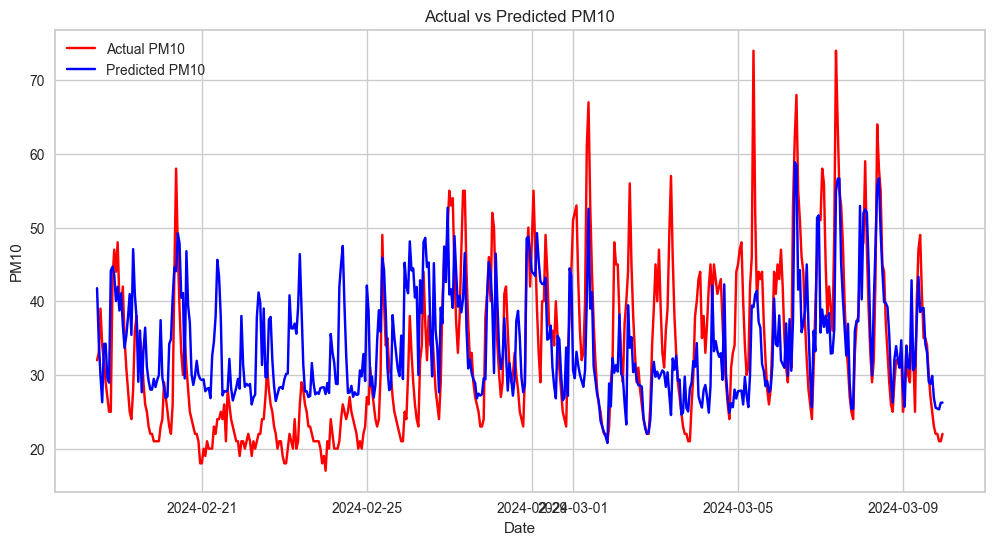

In [79]:
import matplotlib.pyplot as plt
test['DATETIMEDATA'] = pd.to_datetime(test['DATETIMEDATA'])

test = test.sort_values('DATETIMEDATA')
predictions = predictions.sort_values('DATETIMEDATA')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(pre_PM10_test['DATETIMEDATA'], pre_PM10_test['PM10'], color='red', label='Actual PM10')
plt.plot(pre_PM10_test['DATETIMEDATA'], pre_PM10_test['prediction_label'], color='blue', label='Predicted PM10')
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('Actual vs Predicted PM10')
plt.legend()
plt.show()


In [81]:
import pandas as pd

pre_PM10_test['percentage_difference'] = (abs(pre_PM10_test['PM10'] - pre_PM10_test['prediction_label']) / pre_PM10_test['PM10']) * 100

average_percentage_difference = pre_PM10_test['percentage_difference'].mean()
print(f'Average percentage difference: {average_percentage_difference:.2f}%')

pre_PM10_test = pre_PM10_test.drop(columns=['DATETIMEDATA','PM25','O3','CO','NO2','SO2','WS','TEMP','RH','WD'])
pre_PM10_test


Average percentage difference: 23.79%


,PM10,prediction_label,percentage_difference
0,32.0,41.7695,30.529687
1,33.0,34.6100,4.878788
2,39.0,29.9120,23.302564
3,34.0,26.2965,22.657353
4,32.0,34.2070,6.896875
...,...,...,...
488,22.0,25.5495,16.134091
489,22.0,25.4315,15.597727
490,21.0,25.3285,20.611905
491,21.0,26.2270,24.890476
